# Import libraries

In [1]:
%matplotlib inline
from PIL import Image
from os import listdir
from skimage import data, img_as_float
from skimage import exposure
from skimage.filters import gaussian
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from sklearn.metrics import classification_report, confusion_matrix
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import skimage.io as io
import torch
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import warnings
warnings.filterwarnings('ignore')

# UDF

In [2]:
def ImagePathList_perCategory (df, ColumnName, CategoryName):
   return df.loc[df[ColumnName] == CategoryName]['ImagePath'].unique().tolist();

In [3]:
def get_ListOfFiles(path):
    import os
    ListOfFiles=[]
    for root, dirs, files in os.walk(path):
        for filename in files:
            ListOfFiles.append(filename)
    return ListOfFiles

In [4]:
# This function will plot images in the form of a grid with 1 row and length of the images_arr columns.
def plotImages(images_path_arr):
    fig, axes = plt.subplots(1, len(images_path_arr), figsize=(20,20))
    axes = axes.flatten()
    for imagePath, ax in zip( images_path_arr, axes):
        img=mpimg.imread(imagePath)
        if len(img.shape)==3:
            rgb_weights = [0.2989, 0.5870, 0.1140]
            img = np.dot(img[...,:3], rgb_weights)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height>0:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Reload Data

In [6]:
CsvPath='data/data.csv'
df = pd.read_csv(CsvPath)
train=df[df['Dataset_Type']=="train"]
test=df[df['Dataset_Type']=="test"]

# Data Visualization

In [7]:
sample_training_images=[df['ImagePath'][1],
                         df['ImagePath'][2]                       ]


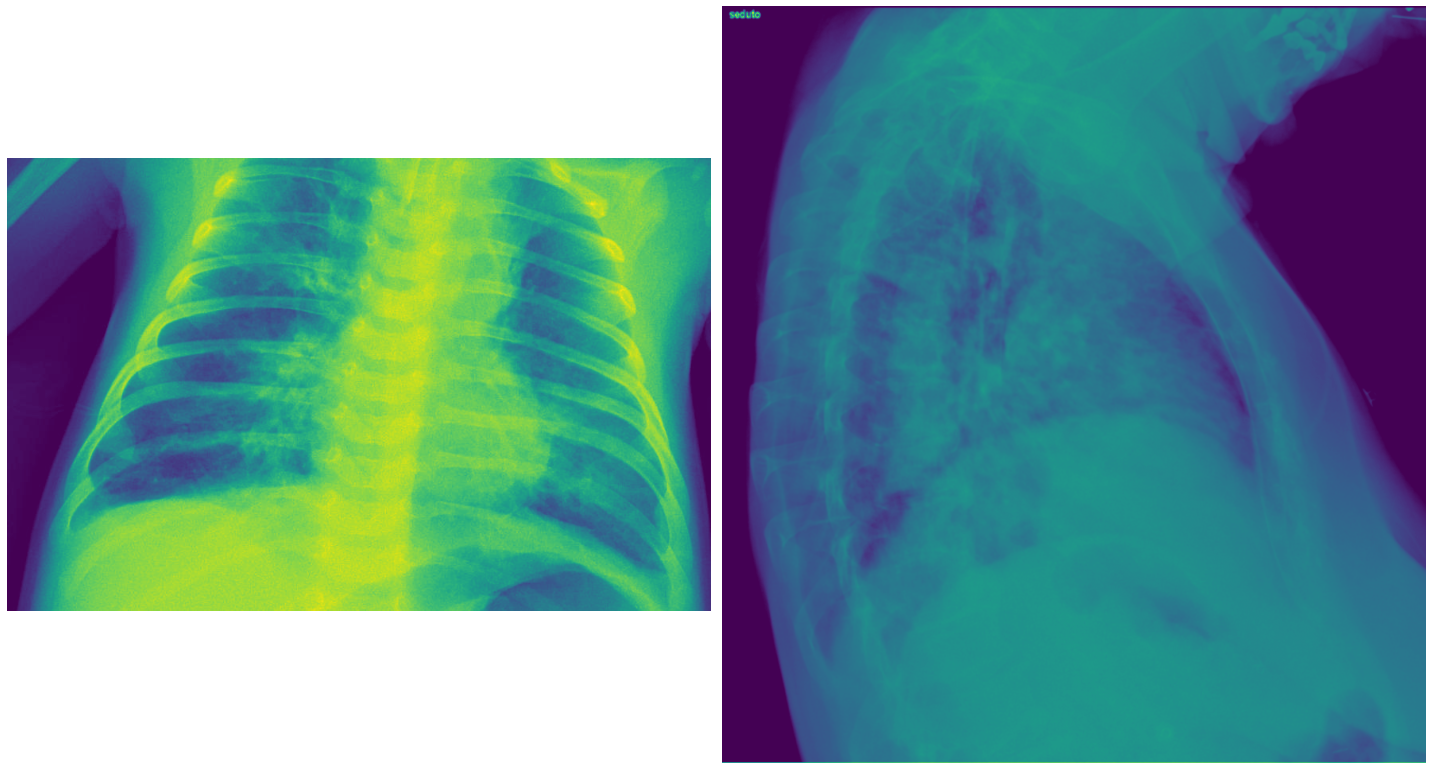

In [8]:
plotImages(sample_training_images)

# Data Distribution & Graphs Visualization

In [9]:
NormalInTrain=len(get_ListOfFiles("data/train/Normal"))
PneumoniaInTrain=len(get_ListOfFiles("data/train/Pnemonia"))
NormalInTest=len(get_ListOfFiles("data/test/Normal"))
PneumoniaIntest=len(get_ListOfFiles("data/test/Pnemonia"))
testSize=len(get_ListOfFiles("data/test"))
trainSize=len(get_ListOfFiles("data/train"))


print(" \t\t Train \t Test \t Total \n Normal \t",NormalInTrain,"\t ",NormalInTest,
      "\t ",NormalInTest+NormalInTrain,
      "\n Pneumonia \t",PneumoniaInTrain,"\t ",PneumoniaIntest,"\t ",PneumoniaIntest+PneumoniaInTrain,
     "\n Total \t\t", trainSize,"\t ",testSize,"\t ", testSize+trainSize)

 		 Train 	 Test 	 Total 
 Normal 	 1097 	  475 	  1572 
 Pneumonia 	 3292 	  1407 	  4699 
 Total 		 4389 	  1882 	  6271


In [10]:
CovidInTest=len(get_ListOfFiles("data/test/Pnemonia/COVID-19"))
CovidInTrain=len(get_ListOfFiles("data/train/Pnemonia/COVID-19"))

NonCovidInTest=len(get_ListOfFiles("data/test/Pnemonia/non-COVID-19"))
NonCovidInTrain=len(get_ListOfFiles("data/train/Pnemonia/non-COVID-19"))

print(" \t\t Train \t Test \t Total \n COVID-19 \t",CovidInTrain,"\t ",CovidInTest,"\t ",CovidInTrain+CovidInTest, 
      "\n non-COVID-19 \t",NonCovidInTrain,"\t ",NonCovidInTest, "\t ",NonCovidInTest+NonCovidInTrain,
     "\n Total \t\t",CovidInTrain+NonCovidInTrain,"\t "
      ,CovidInTest+NonCovidInTest, "\t "
      ,CovidInTrain+CovidInTest+NonCovidInTest+NonCovidInTrain)

 		 Train 	 Test 	 Total 
 COVID-19 	 261 	  112 	  373 
 non-COVID-19 	 1997 	  844 	  2841 
 Total 		 2258 	  956 	  3214


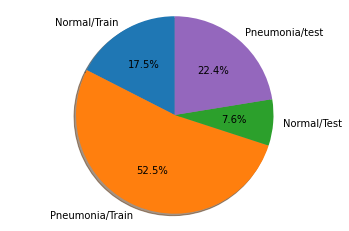

In [11]:
labels = 'Normal/Train', 'Pneumonia/Train', 'Normal/Test', 'Pneumonia/test'
sizes = [NormalInTrain, PneumoniaInTrain, NormalInTest, PneumoniaIntest]
colors = ['C0', 'C1', 'C2', 'C4']
explode = (0, 0, 0, 0)
plt.pie(sizes,explode=explode, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.savefig("Statistics/dataDistribution1.pdf")
plt.savefig("Statistics/dataDistribution1.png")

plt.show()


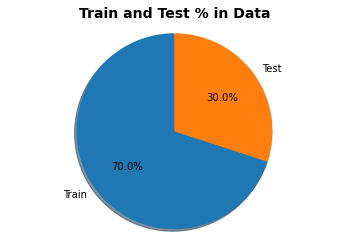

In [12]:
labels = 'Train','Test'
sizes = [NormalInTrain+PneumoniaInTrain, NormalInTest+PneumoniaIntest]
colors = ['C0', 'C1']
plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Train and Test % in Data', weight='bold', size=14)
plt.savefig("Statistics/TrainTestInData.pdf")
plt.savefig("Statistics/TrainTestInData.png")
plt.show()

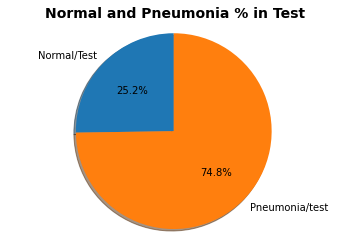

In [13]:
labels= 'Normal/Test', 'Pneumonia/test'
sizes=  [NormalInTest, PneumoniaIntest]
colors = ['C0', 'C1']
plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Normal and Pneumonia % in Test', weight='bold', size=14)
plt.savefig("Statistics/NormalPneumoniaInTest.pdf")
plt.savefig("Statistics/NormalPneumoniaInTest.png")
plt.show()

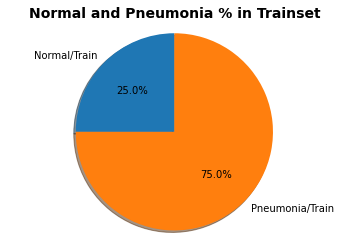

In [14]:
labels = 'Normal/Train', 'Pneumonia/Train'
sizes= [NormalInTrain, PneumoniaInTrain]
colors = ['C0', 'C1']
plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Normal and Pneumonia % in Trainset', weight='bold', size=14)
plt.savefig("Statistics/NormalPneumoniaInTrain.pdf")
plt.savefig("Statistics/NormalPneumoniaInTrain.png")
plt.show()

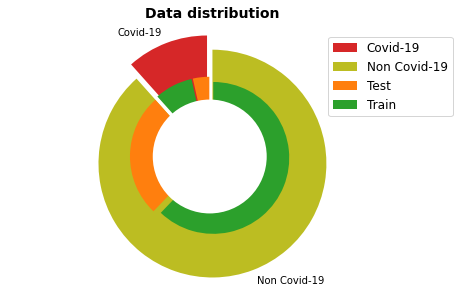

In [15]:
labels = ['Covid-19', 'Non Covid-19']
sizes = [CovidInTest+CovidInTrain , NonCovidInTest+NonCovidInTrain]
labels_gender = ['Test','Train','Test','Train']
sizes_gender = [CovidInTest,CovidInTrain,NonCovidInTest,NonCovidInTrain]
colors = ['C3', 'C8']
colors_gender = ['C11','C12', 'C11','C12']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
#Plot
plt.pie(sizes, labels=labels, colors=colors, startangle=90,frame=True, explode=explode,radius=3 )
plt.pie(sizes_gender, colors=colors_gender,startangle=90, explode=explode_gender,radius=2)

#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()

lgd=plt.legend(['Covid-19', 'Non Covid-19','Test','Train'], fontsize=12,loc='center right', bbox_to_anchor=(1.1, 0.8))
txt=plt.title('Data distribution', weight='bold', size=14)

plt.savefig("Statistics/DataDistribution.pdf",bbox_extra_artists=(lgd,txt), bbox_inches='tight')
plt.savefig("Statistics/DataDistribution.png",bbox_extra_artists=(lgd,txt), bbox_inches='tight')

plt.show()


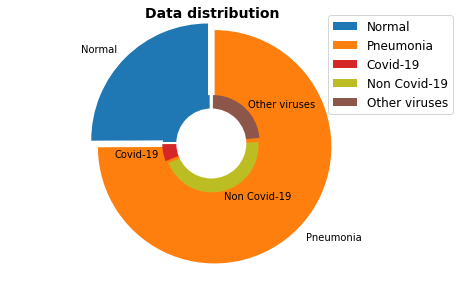

In [16]:
labels0= ['Normal', 'Pneumonia']
sizes0 = [NormalInTest+NormalInTrain , PneumoniaIntest+PneumoniaInTrain]
colors0 = ['C0', 'C1']

labels1 = ['', 'Covid-19', 'Non Covid-19', 'Other viruses']
sizes1 = [NormalInTest+NormalInTrain ,CovidInTest+CovidInTrain , NonCovidInTest+NonCovidInTrain,
          PneumoniaIntest+PneumoniaInTrain-NonCovidInTest-NonCovidInTrain
          -CovidInTest-CovidInTrain]
colors1 = ['C0','C3', 'C8','C5']


explode0 = (0.2,0.2) 
explode1 = (0.1,0.1,0.1,0.1)

#Plot
plt.pie(sizes0,  labels=labels0,colors=colors0, startangle=90,frame=True, explode=explode0,radius=5)
plt.pie(sizes1, labels=labels1, colors=colors1,startangle=90, explode=explode1,radius=2)

#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()


lgd=plt.legend(fontsize=12,loc='center right', bbox_to_anchor=(1.1, 0.8))
txt=plt.suptitle('Data distribution', weight='bold', size=14)

plt.savefig("Statistics/DataDistribution2.pdf",bbox_extra_artists=(lgd,txt), bbox_inches='tight')
plt.savefig("Statistics/DataDistribution2.png",bbox_extra_artists=(lgd,txt), bbox_inches='tight')

plt.show()


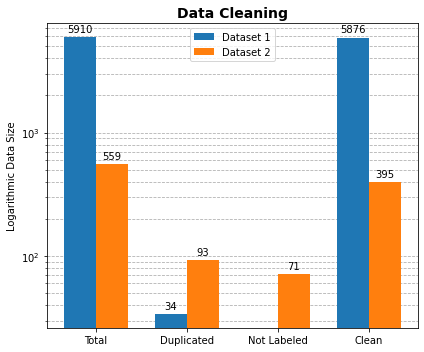

In [17]:
labels = ['Total', 'Duplicated', 'Not Labeled', 'Clean']
data1 = [5910, 5910-5876, 0, 5876]
data2 = [559, 488-395, 559-488, 395]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6,5))
ax.yaxis.grid(True,which="both", linestyle='--')
ax.set_axisbelow(True)
rects1 = ax.bar(x - width/2, data1, width, label='Dataset 1')
rects2 = ax.bar(x + width/2, data2,  width,label='Dataset 2')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Logarithmic Data Size')

ax.set_title('Data Cleaning', weight='bold', size=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_yscale('log')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig("Statistics/DataCleaning.pdf")
plt.savefig("Statistics/DataCleaning.png")

plt.show()